In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 32
num_epochs = 100

z_dimension = 100
num_feature = 4 * 192 * 192

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.ImageFolder('./datas/faces', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
class Discriminator(nn.Module): # b 3 96 96
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2), 
        ) # b 32 48 48
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2),
        ) # b 64 24 24
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(4, 4),
        ) # b 64 6 6
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 6 * 6, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
    
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        out = out.view(x.size(0), -1)
        return self.fc(out)

In [8]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, num_feature)
        ) # b h*w
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.LeakyReLU(.2, True),
        ) # b 1 192 192
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
        ) # b 64 192 192
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
        ) # b 32 192 192
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(32, 3, 3, padding=1, stride=2),
            nn.Tanh(),
        ) # b 1 96 96
        
    def forward(self, x):
        out = self.fc(x)
        out = out.view(x.size(0), 1, 192, 192)
        out = self.br(out)

        out = self.downsample1(out)
        out = self.downsample2(out)
        out = self.downsample3(out)
        return out

In [9]:
d = Discriminator().to(device)
g = Generator(z_dimension, num_feature).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=1e-4)
g_optimezer = optim.Adam(g.parameters(), lr=1e-4)

In [10]:
writer = SummaryWriter('./log/cnn_gan_faces')

In [11]:
total_count = len(dataloader)
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        real_labels = torch.ones(img.size(0), 1).cuda()
        fake_labels = torch.zeros(img.size(0), 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        step = epoch * total_count + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 500 == 0:
            print 'Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean())
    
    if epoch == 0:
        real_images = real_img.view(-1, 3, 96, 96).cpu().data
        save_image(real_images, './cnn_gan_faces/real_images.png')

    fake_images = fake_img.view(-1, 3, 96, 96).cpu().data
    save_image(fake_images, './cnn_gan_faces/fake_images-{}.png'.format(epoch+1))

Epoch [1/100], Step:  16000, d_loss: 0.991278, g_loss: 3.991961, real_scores: 0.743934, fake_scores: 0.059291
Epoch [1/100], Step:  32000, d_loss: 0.797295, g_loss: 2.183367, real_scores: 0.750214, fake_scores: 0.114461
Epoch [1/100], Step:  48000, d_loss: 0.736630, g_loss: 1.333547, real_scores: 0.805306, fake_scores: 0.285971
Epoch [2/100], Step:  16000, d_loss: 0.647582, g_loss: 1.867790, real_scores: 0.687371, fake_scores: 0.136661
Epoch [2/100], Step:  32000, d_loss: 1.168985, g_loss: 1.091902, real_scores: 0.602596, fake_scores: 0.360146
Epoch [2/100], Step:  48000, d_loss: 0.776193, g_loss: 1.295314, real_scores: 0.752099, fake_scores: 0.292020
Epoch [3/100], Step:  16000, d_loss: 0.810710, g_loss: 2.043187, real_scores: 0.700607, fake_scores: 0.251726
Epoch [3/100], Step:  32000, d_loss: 0.962570, g_loss: 1.006101, real_scores: 0.654776, fake_scores: 0.372251
Epoch [3/100], Step:  48000, d_loss: 0.631950, g_loss: 1.984349, real_scores: 0.757054, fake_scores: 0.201973
Epoch [4/1

Epoch [26/100], Step:  16000, d_loss: 0.330576, g_loss: 2.878005, real_scores: 0.959885, fake_scores: 0.207635
Epoch [26/100], Step:  32000, d_loss: 0.737292, g_loss: 2.679759, real_scores: 0.838603, fake_scores: 0.281102
Epoch [26/100], Step:  48000, d_loss: 0.572768, g_loss: 2.273063, real_scores: 0.756363, fake_scores: 0.082893
Epoch [27/100], Step:  16000, d_loss: 0.531958, g_loss: 2.695196, real_scores: 0.768360, fake_scores: 0.093075
Epoch [27/100], Step:  32000, d_loss: 0.281678, g_loss: 2.166823, real_scores: 0.867236, fake_scores: 0.077488
Epoch [27/100], Step:  48000, d_loss: 0.476030, g_loss: 3.516347, real_scores: 0.803132, fake_scores: 0.099854
Epoch [28/100], Step:  16000, d_loss: 0.718263, g_loss: 3.040482, real_scores: 0.917900, fake_scores: 0.283227
Epoch [28/100], Step:  32000, d_loss: 0.312652, g_loss: 3.391207, real_scores: 0.872597, fake_scores: 0.068285
Epoch [28/100], Step:  48000, d_loss: 0.409928, g_loss: 2.694030, real_scores: 0.816470, fake_scores: 0.095520
E

Epoch [50/100], Step:  48000, d_loss: 0.343985, g_loss: 2.143765, real_scores: 0.909126, fake_scores: 0.182047
Epoch [51/100], Step:  16000, d_loss: 0.280888, g_loss: 3.270517, real_scores: 0.883910, fake_scores: 0.052988
Epoch [51/100], Step:  32000, d_loss: 0.389746, g_loss: 3.107667, real_scores: 0.918754, fake_scores: 0.182785
Epoch [51/100], Step:  48000, d_loss: 0.336135, g_loss: 3.104996, real_scores: 0.853231, fake_scores: 0.063518
Epoch [52/100], Step:  16000, d_loss: 0.236309, g_loss: 4.219975, real_scores: 0.876794, fake_scores: 0.048591
Epoch [52/100], Step:  32000, d_loss: 0.316598, g_loss: 3.836891, real_scores: 0.826391, fake_scores: 0.033609
Epoch [52/100], Step:  48000, d_loss: 0.505686, g_loss: 4.640502, real_scores: 0.806713, fake_scores: 0.035932
Epoch [53/100], Step:  16000, d_loss: 0.181239, g_loss: 3.103209, real_scores: 0.941091, fake_scores: 0.072222
Epoch [53/100], Step:  32000, d_loss: 0.361102, g_loss: 2.341710, real_scores: 0.923890, fake_scores: 0.185991
E

Epoch [75/100], Step:  32000, d_loss: 0.297614, g_loss: 4.159874, real_scores: 0.876558, fake_scores: 0.050665
Epoch [75/100], Step:  48000, d_loss: 0.205530, g_loss: 3.576146, real_scores: 0.900793, fake_scores: 0.047930
Epoch [76/100], Step:  16000, d_loss: 0.263301, g_loss: 4.316483, real_scores: 0.892937, fake_scores: 0.036555
Epoch [76/100], Step:  32000, d_loss: 0.246766, g_loss: 3.117741, real_scores: 0.923808, fake_scores: 0.075853
Epoch [76/100], Step:  48000, d_loss: 0.212132, g_loss: 3.105570, real_scores: 0.925381, fake_scores: 0.064029
Epoch [77/100], Step:  16000, d_loss: 0.211705, g_loss: 3.669007, real_scores: 0.940839, fake_scores: 0.118201
Epoch [77/100], Step:  32000, d_loss: 0.408306, g_loss: 3.643083, real_scores: 0.838117, fake_scores: 0.059904
Epoch [77/100], Step:  48000, d_loss: 0.367591, g_loss: 2.052824, real_scores: 0.990734, fake_scores: 0.244966
Epoch [78/100], Step:  16000, d_loss: 0.318234, g_loss: 4.191893, real_scores: 0.910826, fake_scores: 0.085141
E

Process Process-377:
Process Process-380:
Process Process-378:
Process Process-379:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/usr/lib/python2.7/mu

KeyboardInterrupt: 

In [12]:
writer.close()

In [13]:
torch.save(d.state_dict(), './ser/faces_discriminator.pkl')
torch.save(g.state_dict(), './ser/faces_generator.pkl')

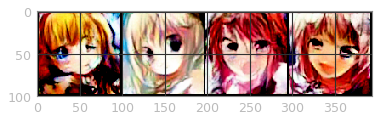

In [19]:
z = torch.randn(4, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()